In [2]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')


# Read and prepare data for analysis

In [3]:
sample_relationships = pd.read_table(sample_relationships_df_loc)
sample_relationships.encapsulation_sibling_sample = sample_relationships.encapsulation_sibling_sample.fillna("")
sample_relationships['emulsion'] = sample_relationships.apply(lambda x: ";".join(sorted([x.sample_uid_vdj, x.encapsulation_sibling_sample])), axis=1)
sample_relationships= sample_relationships.set_index('sample_uid_vdj')



df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[df.vdj_sequence.notna()]
df['emulsion'] = df.sample_uid_vdj.map(sample_relationships['emulsion'])

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)]
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]



## Construct VDJ droplet count dataframe for all vdjs and those known to belong to clean B cells

In [4]:
# def count_and_pivot(data_frame, index_col, column_col, 
#                     fill_value=None,
#                    downsample_to_smallest=False, 
#                    min_vdjs_per_sample=None, 
#                    n_replicates=1):

#     if min_vdjs_per_sample is None:
#         new_df =  data_frame.copy()
#     else:
#         # drop samples with fewer than min_vdjs_per_sample
#         sufficiently_large_sample_uids = data_frame.groupby(column_col)[index_col].nunique()
#         print('dropping the following low-VDJ samples:')
#         print(sufficiently_large_sample_uids[sufficiently_large_sample_uids < min_vdjs_per_sample])
#         sufficiently_large_sample_uids = sufficiently_large_sample_uids[sufficiently_large_sample_uids >= min_vdjs_per_sample].index
#         new_df = data_frame[data_frame[column_col].isin(sufficiently_large_sample_uids)]

#     RETAINED_SAMPLES = new_df[column_col].unique()
#     #drop down to unique vdjs
#     new_df = new_df.groupby([index_col, column_col]).size().reset_index()
#     count_dfs = []
#     for replicate_it in range(n_replicates):
#         if downsample_to_smallest:
#             n = int(new_df.groupby(column_col).size().min())
#             # print(n)
#             count_df = new_df.groupby(column_col).sample(n=n, replace=False)
#             # print(count_df[column_col].value_counts())
#         if fill_value is None:
#             count_df = count_df.pivot(index=index_col, columns = column_col, values=0)
#         else:
#             count_df = count_df.pivot(index=index_col, columns = column_col, values=0).fillna(fill_value).astype('int64')
#         count_df['replicate'] = replicate_it  + 1
#         count_df = count_df.reset_index().set_index([index_col, 'replicate'])
#         count_dfs.append(count_df)
    
#     count_df = pd.concat(count_dfs, axis=0)
#     return count_df, RETAINED_SAMPLES

# cell_counts_all, RETAINED_SAMPLES = count_and_pivot(df, 'vdj_sequence', 'emulsion', 
#                                   downsample_to_smallest=True,
#                                   min_vdjs_per_sample=3000,
#                                   n_replicates=100)
# import warnings
# warnings.filterwarnings(action='ignore')
# new_cols_all = {}
# for col in cell_counts_all.columns:
#     if col != 'replicate':
#         new_cols_all.update({f'{col}_binned':2**round(np.log10(cell_counts_all[col])/np.log10(2))})
#         new_cols_all.update({f'{col}_binarized': cell_counts_all[col].notna()})

# new_cols_all = pd.DataFrame(new_cols_all)
# cell_counts_all = cell_counts_all.join(new_cols_all)

# sample_relationships = sample_relationships[sample_relationships.emulsion.isin(RETAINED_SAMPLES)]

# cell_counts_all.to_csv('cell_counts_all_min_vdjs_3000_n_replicates_100.tsv.gz', sep='\t')

## Set up data structures for sharing analysis

In [5]:
cell_counts_all = pd.read_table('cell_counts_all_min_vdjs_3000_n_replicates_100.tsv.gz')

In [6]:
n_vdjs = df.groupby(['emulsion'])['vdj_sequence'].nunique().sort_values()
expected_emulsions = n_vdjs[n_vdjs >= 3000].index
RETAINED_SAMPLES = [x for x in cell_counts_all.columns if x.startswith(("TBd",";")) and not x.endswith(("binned", "binarized"))]
print(all(x in RETAINED_SAMPLES for x in expected_emulsions))
print(all(x in expected_emulsions for x in RETAINED_SAMPLES))

True
True


In [7]:
sample_relationships = sample_relationships[sample_relationships.emulsion.isin(RETAINED_SAMPLES)]

In [8]:
tissue_list = ['PB','BM','SP','LN']
tissue_indices = {'PB':0, 'BM':1, 'SP':2, 'LN':3}

clean_samples=df_clean.emulsion[df_clean.emulsion.notna()].unique()
sample_relationships['tissue'] = sample_relationships.donor_tissue.map(lambda x: x.split("_")[-1])
tissue_dict = sample_relationships[['emulsion','tissue']].drop_duplicates(ignore_index=True).set_index('emulsion')['tissue'].to_dict()

donor_tissue_list = sample_relationships.groupby('donor_tissue')['emulsion'].unique()
donor_tissue_availability = sample_relationships.groupby('donor')['donor_tissue'].unique()

sibling_pairs = sample_relationships.encapsulation_sibling_sample[sample_relationships.encapsulation_sibling_sample.notna()].to_dict()
sample_replicates = sample_relationships.reset_index().groupby(['cell_suspension'])['emulsion'].agg(list).to_dict()
tissue_replicates = sample_relationships.reset_index().groupby(['donor_tissue'])['emulsion'].agg(list).to_dict()
sample_replicate_dict = {}
for cell_suspension, samples in sample_replicates.items():
    for x in samples:
        sample_replicate_dict.update({x:[y for y in samples if not (y == x)]})
        
tissue_replicate_dict = {}
for tissue, samples in tissue_replicates.items():
    for x in samples:
        exclude=[x] + sample_replicate_dict.get(x)
        if len(exclude) < len(samples):
            tissue_replicate_dict.update({x:[y for y in samples if not (y in exclude)]})


In [9]:
norm_dict = {x:sample_replicate_dict.get(x,[]) + tissue_replicate_dict.get(x,[]) 
             for x in (list(sample_replicate_dict.keys()) + list(tissue_replicate_dict.keys()))}
test_dict = {(t,dt):{} for t, dt in permutations(tissue_list,2)}
for t, dt in test_dict.keys():
        relevant_donors = [d for d in donors if (f'{d}_{t}' in donor_tissue_availability[d]) 
                                            and (f'{d}_{dt}' in donor_tissue_availability[d])]
        for d in relevant_donors:
            test_dict[(t,dt)].update({d:
                                      {x:[y 
                                          for y in donor_tissue_list[f'{d}_{dt}']
                                         ] 
                                      for x in donor_tissue_list[f'{d}_{t}']
                                      } 
                                     })
pair_test_dict = {(t1, t2, dt):{} for t1, t2, dt in permutations(tissue_list,3)
                 if tissue_indices[t1] < tissue_indices[t2]}
pair_norm_dict = {}

for t1, t2, dt in pair_test_dict.keys():

        relevant_donors = [d for d in donors if ((f'{d}_{t1}' in donor_tissue_availability[d])
                                            and (f'{d}_{t2}' in donor_tissue_availability[d])) 
                                            and (f'{d}_{dt}' in donor_tissue_availability[d])]
        for d in relevant_donors:
            t1_samples = [x for x in donor_tissue_list[f'{d}_{t1}']]
            t2_samples = [x for x in donor_tissue_list[f'{d}_{t2}']]
            dt_samples = [x for x in donor_tissue_list[f'{d}_{dt}']]
            
            pair_test_dict[(t1,t2,dt)].update({d:{(x,y):[z for z in dt_samples]
                                                for x in t1_samples
                                                for y in t2_samples}})
            pair_norm_dict.update({(x,y):norm_dict[x] + norm_dict[y]
                                            for x in t1_samples
                                            for y in t2_samples
                                           })
            
triplet_test_dict = {(t1, t2, t3, dt):{} for t1, t2, t3, dt in permutations(tissue_list,4)
                 if (tissue_indices[t1] < tissue_indices[t2])
                 and (tissue_indices[t2] < tissue_indices[t3])}
triplet_norm_dict = {}

for t1, t2, t3, dt in triplet_test_dict.keys():

        relevant_donors = [d for d in donors if (((f'{d}_{t1}' in donor_tissue_availability[d])
                                              and (f'{d}_{t2}' in donor_tissue_availability[d]))
                                             and (f'{d}_{t3}' in donor_tissue_availability[d]))
                                             and (f'{d}_{dt}' in donor_tissue_availability[d])]
        for d in relevant_donors:
            t1_samples = [x for x in donor_tissue_list[f'{d}_{t1}']]
            t2_samples = [x for x in donor_tissue_list[f'{d}_{t2}']]
            t3_samples = [x for x in donor_tissue_list[f'{d}_{t3}']]
            dt_samples = [x for x in donor_tissue_list[f'{d}_{dt}']]
            
            triplet_test_dict[(t1,t2,t3,dt)].update({d:{(x,y,z):[z for z in dt_samples]
                                                for x in t1_samples
                                                for y in t2_samples
                                                for z in t3_samples}})
            triplet_norm_dict.update({(x,y,z):norm_dict[x] + norm_dict[y] + norm_dict[z]
                                            for x in t1_samples
                                            for y in t2_samples
                                            for z in t3_samples
                                           })

## Define function to calculate relative sharing amounts

In [10]:
def calculate_discovery_prob_unscaled(data_frame, test_dict, 
                                     filter_on = [],
                                     filter_col_suffix='labels'):
    all_freqs = []
    for k in test_dict.keys():
        test_cols = [f'{x}_binarized' for x in test_dict[k]]
        
        if type(k) is tuple:
            n_keys = len(k)
            present = data_frame[[f'{s}_binarized' for s in k]].sum(axis=1) == n_keys
        else:
            n_keys = 1
            present = data_frame[f'{k}_binarized']
        
        if len(filter_on) > 0:
            if type(k) is tuple:
                filter_cols = [f'{s}_{filter_col_suffix}' for s in k ]
            else:
                filter_cols = [f'{k}_{filter_col_suffix}']
            
            _filter = (data_frame[filter_cols].isin(filter_on)).all(axis=1)
            present = present & _filter
        
        freqs = data_frame.groupby([present,'replicate'])[test_cols].mean()

        freqs[f'{k}_test_mean'] = freqs[test_cols].mean(axis=1)
        all_freqs.append(freqs[f'{k}_test_mean'])
    if len(all_freqs)>0:
        all_freqs = pd.concat(all_freqs, axis=1)

        all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].mean(axis=1)
        all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].std(axis=1)
        ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
        all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))
        try:
            all_freqs = all_freqs.reset_index()
            all_freqs = all_freqs.groupby(['level_0']).mean()
            all_freqs = all_freqs.T[True].T
        except KeyError:
            all_freqs =  pd.Series(index=['mean_ratio', 'std_ratio', 'std_err'], dtype=pd.Float64Dtype)
    else:
        all_freqs = pd.DataFrame()
    return all_freqs

def calculate_discovery_prob_scaled(data_frame, 
                                    norm_dict, 
                                    test_dict,
                                    filter_on = [],
                                    filter_col_suffix='labels',
                                    debug=False):
    all_freqs = []
    EPS=1
    for k in test_dict.keys():
        norm_cols = [f'{x}_binarized' for x in norm_dict[k]]
        test_cols = [f'{x}_binarized' for x in test_dict[k]]
        all_cols = norm_cols + test_cols

        if type(k) is tuple:
            n_keys = len(k)
            present = data_frame[[f'{s}_binarized' for s in k]].sum(axis=1) == n_keys
            key_string = "_".join(list(k))
        else:
            n_keys = 1
            present = data_frame[f'{k}_binarized']
            key_string = k
            
        if len(filter_on) > 0:
            if type(k) is tuple:
                filter_cols = [f'{s}_{filter_col_suffix}' for s in k]
            else:
                filter_cols = [f'{k}_{filter_col_suffix}']
            
            _filter = (data_frame[filter_cols].isin(filter_on)).all(axis=1)
            present = present & _filter
        
        freqs = data_frame.groupby([present, 'replicate'])[all_cols].sum()
        freqs[f'{key_string}_norm_mean'] = freqs[norm_cols].mean(axis=1)
        freqs[f'{key_string}_test_mean'] = freqs[test_cols].mean(axis=1)
        freqs[f'{key_string}_ratio'] = (freqs[f'{key_string}_test_mean']+EPS)\
                                        /(freqs[f'{key_string}_norm_mean']+EPS)
        all_freqs.append(freqs[[f'{key_string}_norm_mean', 
                                f'{key_string}_test_mean', 
                                f'{key_string}_ratio']])

    if len(all_freqs) > 0:
        all_freqs = pd.concat(all_freqs, axis=1)
    
        all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].mean(axis=1)
        all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].std(axis=1)
        ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
        all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))

        try:
            all_freqs = all_freqs.reset_index()
            all_freqs = all_freqs.groupby(['level_0']).mean()
            all_freqs = all_freqs.T[True].T
        except KeyError:
            all_freqs = pd.Series(index=['mean_ratio', 'std_ratio', 'std_err'], dtype=pd.Float64Dtype)
    else:
        all_freqs = pd.Series()
    return all_freqs


## Now calculate sharing statistics

In [11]:
tissue_list = ['PB', 'BM', 'SP', 'LN']
tissue_pairs = list(combinations(tissue_list,2))
tissue_triplets = list(combinations(tissue_list,3))

rows = []
for t1, t2 in test_dict.keys():
    for d, relevant_test_dict in test_dict[(t1,t2)].items():
        probs = calculate_discovery_prob_scaled(cell_counts_all, 
                                                           norm_dict, 
                                                           relevant_test_dict)
        row = pd.Series({'donor':d, 
                         'ascertained_in':f'{t1}',
                         'discovery_tissue':t2,
                         'mean':probs['mean_ratio'],
                         'std_err':probs['std_err'],
                         'n_ascertainment':1})
        rows.append(row)

singlet_prob_df = pd.DataFrame(rows)
singlet_prob_df
rows = []
for t1, t2, t3 in pair_test_dict.keys():
    for d, relevant_test_dict in pair_test_dict[(t1,t2,t3)].items():
        probs = calculate_discovery_prob_scaled(cell_counts_all, 
                                                             pair_norm_dict, 
                                                             relevant_test_dict)
        
        row = pd.Series({'donor':d, 
                         'ascertained_in':f'{t1},{t2}',
                         'discovery_tissue':t3,
                         'mean':probs['mean_ratio'],
                         'std_err':probs['std_err'],
                         'n_ascertainment':2})
        rows.append(row)
pair_prob_df = pd.DataFrame(rows)

rows = []
for t1, t2, t3, dt in triplet_test_dict.keys():
    for d, relevant_test_dict in triplet_test_dict[(t1,t2,t3,dt)].items():
        probs = calculate_discovery_prob_scaled(cell_counts_all, 
                                                             triplet_norm_dict, 
                                                             relevant_test_dict)
        row = pd.Series({'donor':d, 
                         'ascertained_in':f'{t1},{t2},{t3}',
                         'discovery_tissue':dt,
                         'mean':probs['mean_ratio'],
                         'std_err':probs['std_err'],
                         'n_ascertainment':3})
        rows.append(row)

triplet_prob_df = pd.DataFrame(rows)

prob_df = pd.concat([singlet_prob_df, pair_prob_df, triplet_prob_df])


In [12]:

rows = []
for t1, t2 in test_dict.keys():
    for d, relevant_test_dict in test_dict[(t1,t2)].items():
        probs = calculate_discovery_prob_unscaled(cell_counts_all, 
                                                           relevant_test_dict)
        row = pd.Series({'donor':d, 
                         'ascertained_in':f'{t1}',
                         'discovery_tissue':t2,
                         'mean':probs['mean_ratio'],
                         'std_err':probs['std_err'],
                         'n_ascertainment':1})
        rows.append(row)

for t1, t2, t3 in pair_test_dict.keys():
    for d, relevant_test_dict in pair_test_dict[(t1,t2,t3)].items():
        probs = calculate_discovery_prob_unscaled(cell_counts_all, 
                                                             relevant_test_dict)
        row = pd.Series({'donor':d, 
                         'ascertained_in':f'{t1},{t2}',
                         'discovery_tissue':t3,
                         'mean':probs['mean_ratio'],
                         'std_err':probs['std_err'],
                         'n_ascertainment':2})
        rows.append(row)

for t1, t2, t3, dt in triplet_test_dict.keys():
    for d, relevant_test_dict in triplet_test_dict[(t1,t2,t3,dt)].items():
        probs = calculate_discovery_prob_unscaled(cell_counts_all, 
                                                             relevant_test_dict)
        row = pd.Series({'donor':d, 
                         'ascertained_in':f'{t1},{t2},{t3}',
                         'discovery_tissue':dt,
                         'mean':probs['mean_ratio'],
                         'std_err':probs['std_err'],
                         'n_ascertainment':3})
        rows.append(row)
unscaled_prob_df = pd.DataFrame(rows)

# unscaled_prob_df

## Plot

In [13]:
# drop nan's
prob_df = prob_df[prob_df['mean'].notna()]
unscaled_prob_df = unscaled_prob_df[unscaled_prob_df['mean'].notna()]

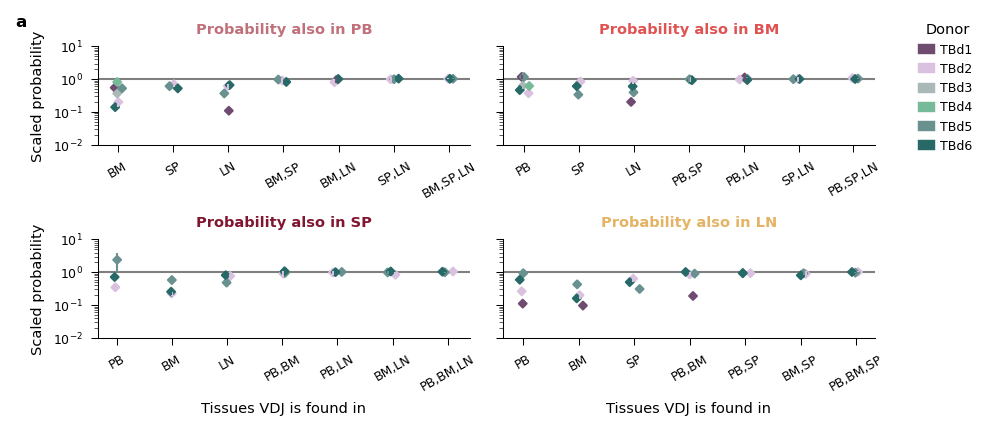

In [14]:
fig, ax = plt.subplots(2,2, figsize=(6.5,3), sharey=True)
ax = ax.flatten()
palette = donor_colors
for i, tissue in enumerate(tissue_list):
    relevant_df = prob_df[prob_df.discovery_tissue == tissue]
    if len(relevant_df) < 1:
        continue

    ascertained_ids = {k:i for i,k in enumerate(relevant_df['ascertained_in'].unique())}
    xticklabels = relevant_df['ascertained_in'].unique()
    xticks = np.arange(len(relevant_df['ascertained_in'].unique()))
                       
    jitter = np.random.uniform(0, .2, size= relevant_df.shape[0]) -.1
    xvals = relevant_df['ascertained_in'].map(ascertained_ids) + jitter
    yvals = relevant_df['mean']
    colors = relevant_df['donor'].map(palette)
    errors = relevant_df['std_err']
    
    ax[i].scatter(xvals, yvals, color=colors, clip_on=False, marker='D', s=7)

    ax[i].errorbar(xvals,
                   yvals,
                   2*errors, 
                   ecolor=colors,
                   fmt=' ')
    ax[i].set_yscale('log')
    ax[i].set_ylim([10**-2,10])
    ax[i].set_title(f'Probability also in {tissue}', weight='bold', color=tissue_colors[tissue])
    if i < 2:
        ax[i].set_xlabel(f'')
    else:
        ax[i].set_xlabel(f'Tissues VDJ is found in')
    ax[i].axhline(y=1, color='k', alpha=0.5, zorder=-1)
    if i in [0,2]:
        ax[i].set_ylabel('Scaled probability')
    else:
        ax[i].set_ylabel('')
    ax[i].set_xticks(xticks,xticklabels)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(30)
    r,g,b,a = mpl.colors.to_rgba(tissue_colors[tissue])
    bg_color = (r,g,b,0.5)
    # ax[i].set_facecolor(bg_color)
# sns.move_legend(g_legend, title='Donor', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
for donor in donors:
    ax[1].plot([],[],lw=5,label=donor, color=palette[donor])
ax[1].legend(title='Donor', loc='upper left', bbox_to_anchor=(1.1,1.35), frameon=False, handlelength=0.5)
fig.tight_layout()
ax[0].text(0,0.9, 'a', weight='bold', fontsize=8, transform=fig.transFigure)
fig.savefig(f'../figures/paper figures/Figure3a_EPS_1_downsample_3000.pdf', bbox_inches='tight')

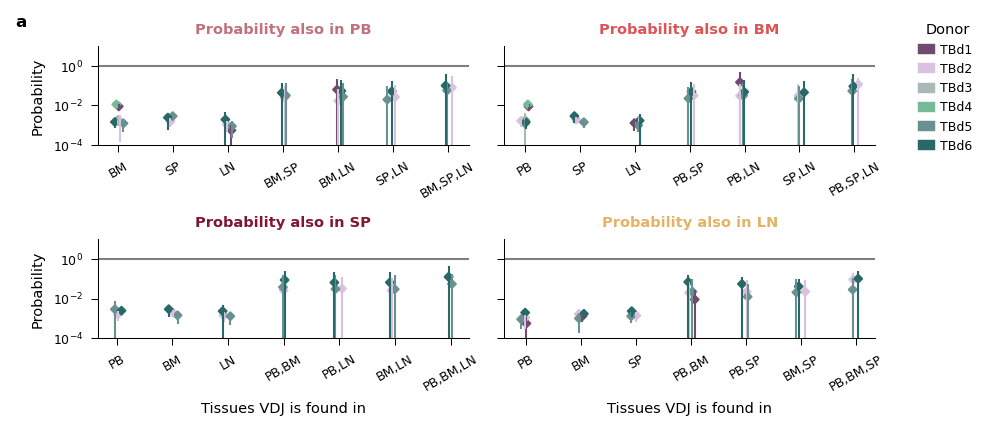

In [15]:
fig, ax = plt.subplots(2,2, figsize=(6.5,3), sharey=True)
ax = ax.flatten()
palette = donor_colors
for i, tissue in enumerate(tissue_list):
    relevant_df = unscaled_prob_df[unscaled_prob_df.discovery_tissue == tissue]
    if len(relevant_df) < 1:
        continue

    ascertained_ids = {k:i for i,k in enumerate(relevant_df['ascertained_in'].unique())}
    xticklabels = relevant_df['ascertained_in'].unique()
    xticks = np.arange(len(relevant_df['ascertained_in'].unique()))
                       
    jitter = np.random.uniform(0, .2, size= relevant_df.shape[0]) -.1
    xvals = relevant_df['ascertained_in'].map(ascertained_ids) + jitter
    yvals = relevant_df['mean']
    colors = relevant_df['donor'].map(palette)
    errors = relevant_df['std_err']
    
    ax[i].scatter(xvals, yvals, color=colors, clip_on=False, marker='D', s=7)

    try: 
        ax[i].errorbar(xvals,
                   yvals,
                   2*errors, 
                   ecolor=colors,
                   fmt=' ')
    except ValueError:
        print(tissue, errors)
    ax[i].set_yscale('log')
    ax[i].set_ylim([10**-4,10])
    ax[i].set_title(f'Probability also in {tissue}', weight='bold', color=tissue_colors[tissue])
    if i < 2:
        ax[i].set_xlabel(f'')
    else:
        ax[i].set_xlabel(f'Tissues VDJ is found in')
    ax[i].axhline(y=1, color='k', alpha=0.5, zorder=-1)
    if i in [0,2]:
        ax[i].set_ylabel('Probability')
    else:
        ax[i].set_ylabel('')
    ax[i].set_xticks(xticks,xticklabels)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(30)
    r,g,b,a = mpl.colors.to_rgba(tissue_colors[tissue])
    bg_color = (r,g,b,0.5)
    # ax[i].set_facecolor(bg_color)
# sns.move_legend(g_legend, title='Donor', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
for donor in donors:
    ax[1].plot([],[],lw=5,label=donor, color=palette[donor])
ax[1].legend(title='Donor', loc='upper left', bbox_to_anchor=(1.1,1.35), frameon=False, handlelength=0.5)
fig.tight_layout()
fig.savefig(f'../figures/paper figures/unscaled_Figure3a_EPS_1_downsample_3000.pdf', bbox_inches='tight')